# Введение в нейронные сети

## Домашнее задание 5. Рекуррентные нейронные сети

#### 1. Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

#### 1.1 Попытка для датасета airline-passangers

In [200]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [201]:
import os
import datetime

Читаем данные из файла со значениями (потребление энергии дневные отсчеты)

In [226]:
df = pd.read_csv('airline-passengers.csv')
df.index = df.Month
df.drop(columns=['Month'], inplace=True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [227]:
df.sort_index(ascending=True, inplace=True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


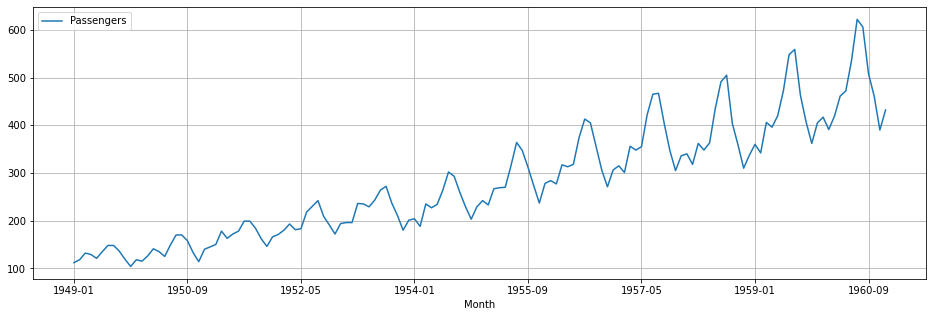

In [228]:
df.plot(figsize = (16,5))
plt.grid('On')
plt.show()

Добавим дату как признаки:
как "месяц в году"/12 и (год-1949)

In [229]:
df['month'] = pd.to_datetime(df.index).month/12
df['year'] = pd.to_datetime(df.index).year - 1949

Добавим скользящую среднюю за четыре месяца, как признак

In [230]:
#df['ma'] = df['Passengers'].rolling(window=4).mean()

Отбросим данные с пропусками

In [231]:
#df.dropna(inplace=True)
#df.head()

In [232]:
#
data = df.copy() # берем все что есть

In [233]:
data.head()

,Passengers,month,year
Month,,,
1949-01,112,0.083333,0
1949-02,118,0.166667,0
1949-03,132,0.250000,0
1949-04,129,0.333333,0
1949-05,121,0.416667,0


Делаем масштабирование признаков через MinMaxScaler

In [234]:
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
#data[['Passengers', 'ma', 'year']] = scaler.fit_transform(data[['Passengers', 'ma', 'year']])
data[['Passengers', 'year']] = scaler.fit_transform(data[['Passengers', 'year']])

In [235]:
data

,Passengers,month,year
Month,,,
1949-01,0.015444,0.083333,0.0
1949-02,0.027027,0.166667,0.0
1949-03,0.054054,0.250000,0.0
1949-04,0.048263,0.333333,0.0
1949-05,0.032819,0.416667,0.0
...,...,...,...
1960-08,0.969112,0.666667,1.0
1960-09,0.779923,0.750000,1.0
1960-10,0.689189,0.833333,1.0


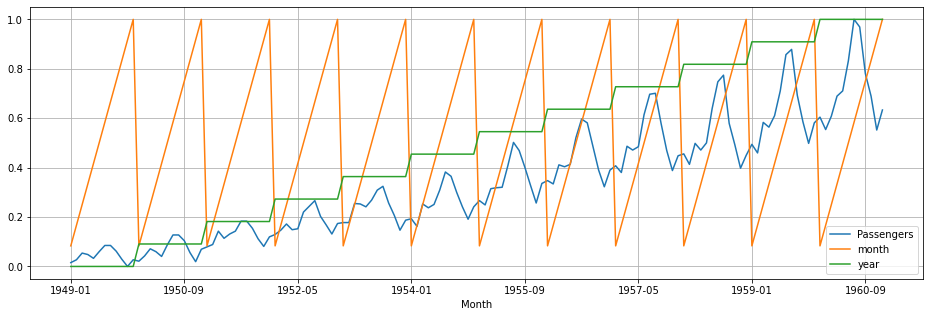

In [236]:
data.plot(figsize = (16,5))
plt.grid('On')
plt.show()

Создаем данные для обучения

In [242]:
# список признаков, по которым будем учить
channelIndexes = [0,1,2]

# длина теста
valLen = 30
# длина истории для работы
xLen = 6
# отступ тестов от тренировок
bias = 6

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data.shape[0] - valLen - bias
# делим
train_data = data.iloc[0:train_split, :]
val_data = data.iloc[train_split+bias:, :]

In [243]:
train_data.head(3)

,Passengers,month,year
Month,,,
1949-01,0.015444,0.083333,0.0
1949-02,0.027027,0.166667,0.0
1949-03,0.054054,0.250000,0.0


Формируем параметры для генерации выборки

In [244]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 4
epochs = 10

Выделяем части на обучение и проверку

In [245]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [246]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(102, 3)
(102,)
(24, 3)
(24,)


Посмотрим на них

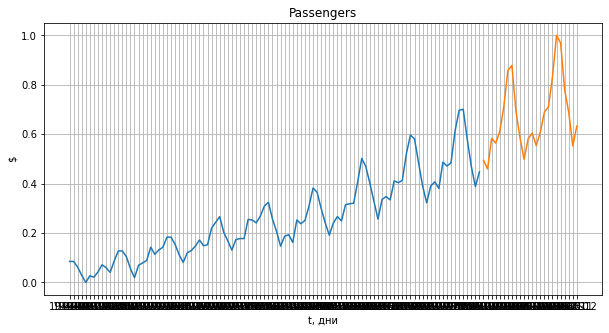

In [247]:
plt.figure(figsize=(10,5))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Passengers')
plt.show()

Используем механизм формирования пакетов для обучения

In [248]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [249]:
dataset_train

<BatchDataset shapes: ((None, None, 3), (None,)), types: (tf.float64, tf.float64)>

In [250]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (4, 6, 3)
Target shape: (4,)


**сеть:  LSTM слои+Dense слой.**

Epoch 1/100
25/25 [==============================] - 3s 53ms/step - loss: 0.0083 - mae: 0.0736 - val_loss: 0.0221 - val_mae: 0.1278
Epoch 2/100
25/25 [==============================] - 1s 38ms/step - loss: 0.0049 - mae: 0.0577 - val_loss: 0.0100 - val_mae: 0.0804
Epoch 3/100
25/25 [==============================] - 1s 38ms/step - loss: 0.0181 - mae: 0.1164 - val_loss: 0.0125 - val_mae: 0.0949
Epoch 4/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0097 - mae: 0.0840 - val_loss: 0.0086 - val_mae: 0.0702
Epoch 5/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0233 - mae: 0.1266 - val_loss: 0.0291 - val_mae: 0.1355
Epoch 6/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0035 - mae: 0.0466 - val_loss: 0.0099 - val_mae: 0.0732
Epoch 7/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0039 - mae: 0.0502 - val_loss: 0.0101 - val_mae: 0.0731
Epoch 8/100
25/25 [==============================] - 1s 37ms/step - loss: 0.

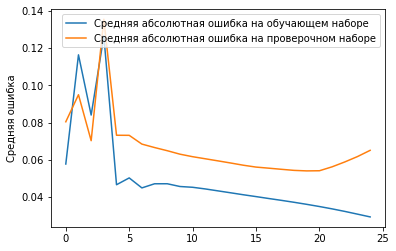

In [273]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(32, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))

model.add(Flatten())                          # (None, n_Dense*n_lstm)
model.add(Dense(32, activation="linear"))      # (None,n_Dense)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    callbacks=[callbaсk])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [274]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [275]:
predVal

array([0.51232487, 0.55923706, 0.59118754, 0.60454905, 0.6426788 ,
       0.7406492 , 0.8572385 , 0.84210783, 0.8260737 , 0.7557621 ,
       0.6990602 , 0.66168016, 0.6319807 , 0.6753257 , 0.70269877,
       0.71062666, 0.7709815 , 0.8863692 , 1.0044917 ], dtype=float32)

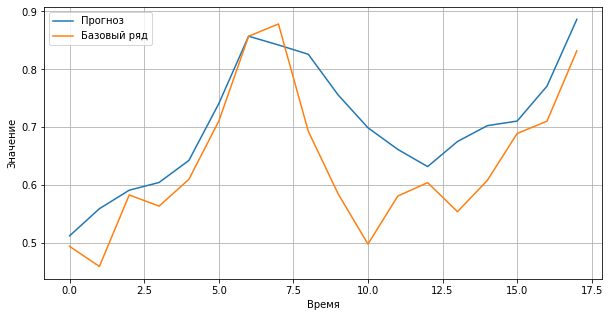

In [276]:
start = 0
step = 18
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')

plt.legend()
plt.show()

Визуально получен довольно правдоподобный прогноз

#### Что помогло вам улучшить ее точность?

В итоге лучше всего отработала самая простая модель с MinMaxScaler.

Что еще пробовал:
- StandartScaler показал себя хуже MinMaxScaler;
- введение дополнительной "фичи" - скользящее среднее на разных интервалах (от 1 месяца до года) "сглаживало" результат, при этом ухудшая его;
- увеличение количества ядер ухудшало результат, добавление дополнительных Dense слоев не улучшало результат;
- немного улучшило качество уменьшение размера batch, в связи с небольшим объемом примеров.

Также попробовал работу модели для предсказания котировок цен на относительно сезонный продукт - пшеницу, однако качество получилось совсем плохим, требуется намного больше времени на доработку, так что результат не презентую.

P.S. Написать самостоятельную реализацию не хватает знаний, продолжу работать над этим.